In [2]:
import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [3]:
def get_batch_data():
    BUFFER_SIZE = 10000
    BATCH_SIZE = 64
    padded_shapes = ([None], ())
    
    (train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split=(tfds.Split.TRAIN, tfds.Split.TEST), with_info=True, as_supervised=True)
    encoder = info.features['text'].encoder
    
    train_batches = train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
    test_batches = test_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
    return (train_batches, test_batches, encoder)

In [4]:
def get_model(encoder, embedding_dim=16):
    model = keras.Sequential([
        layers.Embedding(encoder.vocab_size, embedding_dim), 
        layers.Bidirectional(keras.layers.LSTM(64)), 
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def plot_history(history):
    
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim((0.5,1))
    plt.show()

In [6]:
def retrieve_embeddings(model, encoder):
    out_vectors = io.open('vecs.tsv', 'w', encoding='utf-8')
    out_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
    weights = model.layers[0].get_weights()[0]
    for num, word in enumerate(encoder.subwords):
        vec = weights[num+1]
        out_metadata.write(word + '\n')
        out_vectors.write('\t'.join([str(x) for x in vec]) + '\n')
        
    out_vectors.close()
    out_metadata.close()

In [7]:
def pad_to_size(vec, size):
    zeroes = [0]*(size-len(vec))
    vec.extend(zeroes)
    return vec

In [24]:
def sample_predict(sentence, pad=True):
    encoded_sample_pred_text = encoder.encode(sentence)
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
    
    return predictions

Shuffling and writing examples to /Users/oscarchen/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU2ZRVB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /Users/oscarchen/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU2ZRVB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /Users/oscarchen/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU2ZRVB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /Users/oscarchen/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Epoch 1/5
391/391 [==============================] - 187s 479ms/step - loss: 0.6932 - accuracy: 0.5194 - val_loss: 0.6919 - val_accuracy: 0.5125
Epoch 2/5
391/391 [==============================] - 187s 478ms/step - loss: 0.6518 - accuracy: 0.6486 - val_loss: 0.5111 - val_accuracy: 0.7437
Epoch 3/5
391/391 [==============================] - 195s 498ms/step - loss: 0.3906 - accuracy: 0.8412 - val_loss: 0.3488 - val_accuracy: 0.8633
Epoch 4/5
391/391 [==============================] - 189s 483ms/step - loss: 0.2802 - accuracy: 0.8942 - val_loss: 0.3058 - val_accuracy: 0.8727
Epoch 5/5
391/391 [==============================] - 191s 488ms/step - loss: 0.2375 - accuracy: 0.9130 - val_loss: 0.3111 - val_accuracy: 0.8750


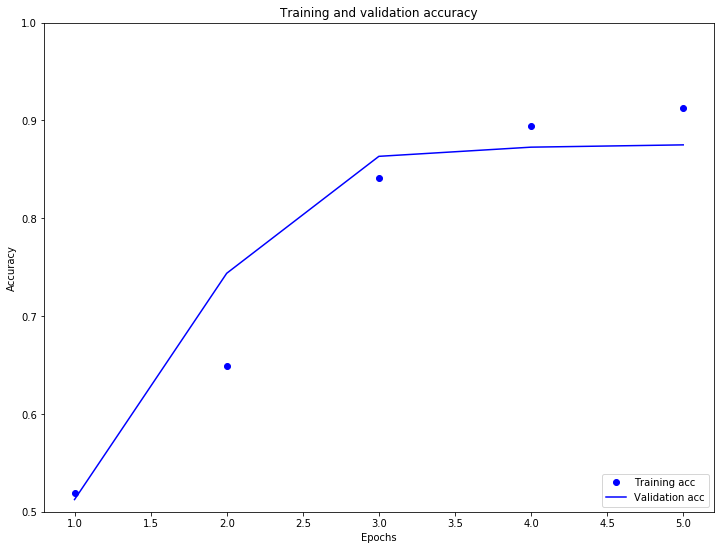

In [9]:
train_batches, test_batches, encoder = get_batch_data()
model = get_model(encoder)
history = model.fit(train_batches, epochs=5, validation_data=test_batches, validation_steps=20)
plot_history(history)
retrieve_embeddings(model, encoder)

In [26]:
sample_text = ('Awesome, very good, incredible performance. highly recommended.')
predictions = sample_predict(sample_text)
predictions

array([[0.8143523]], dtype=float32)